Intentamos otra arquitectura propia basada en Unet

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#https://colab.research.google.com/drive/1I71fcobEI5uUR_8vaaXZHMw4vQX00C-W
import math
import glob
import random

import gym
import numpy as np
from sklearn import metrics, manifold
from matplotlib import pyplot as plt

import keras
from keras.layers import Input, Conv2DTranspose,Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, Conv1D, MaxPool1D, Lambda, Multiply,UpSampling2D
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import np_utils 
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras import backend as K

def rescale(x):
    mask = K.cast(x >= .5, dtype=K.floatx())
    return mask + (x) * (1-mask)




lambda x: 1 if x > 0.5 == 0 else 0

['stanford-car-dataset-by-classes-folder', 'carvana-image-masking-challenge', 'intel-image-classification', '12v2-tfm-cardrawing-try-merge-background-dat', 'manualdraw']


Using TensorFlow backend.


<function __main__.<lambda>(x)>

In [2]:
!ls '../input/12v2-tfm-cardrawing-try-merge-background-dat'

__notebook__.ipynb  __results__.html   custom.css
__output__.json     __results___files  unet-carvana-augmented.hdf5


Leemos el modelos Unet

Hemos entrenado el modelo en el Notebook 12, erpo en el 12 hemos echado un vistazo rapido al Standford cars, intentaremos analizar un poco mas a fondo el comportamento de la unet sobre el StandFord y mirar si podemos detectar cosas

In [3]:
model_file = '../input/12v2-tfm-cardrawing-try-merge-background-dat/unet-carvana-augmented.hdf5'
model=load_model(model_file)
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
________________________________________________________________________

In [4]:
standfordcars_train = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
standfordcars_test = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'

images=[]
for x in os.listdir(standfordcars_train):
    for image in os.listdir(standfordcars_train+'/'+str(x)):
        extension = os.path.splitext(image)[1]        
        if (extension=='.jpg'):
            images.append(standfordcars_train+'/'+str(x)+'/'+image)
        
for x in os.listdir(standfordcars_test):
    for image in os.listdir(standfordcars_test+'/'+str(x)):
        extension = os.path.splitext(image)[1]
        if (extension=='.jpg'):
            images.append(standfordcars_test+'/'+str(x)+'/'+image)
        
print(len(images))
images[0:5]

16185


['../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Bentley Continental GT Coupe 2012/07754.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Bentley Continental GT Coupe 2012/06005.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Bentley Continental GT Coupe 2012/04613.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Bentley Continental GT Coupe 2012/06800.jpg',
 '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Bentley Continental GT Coupe 2012/00146.jpg']

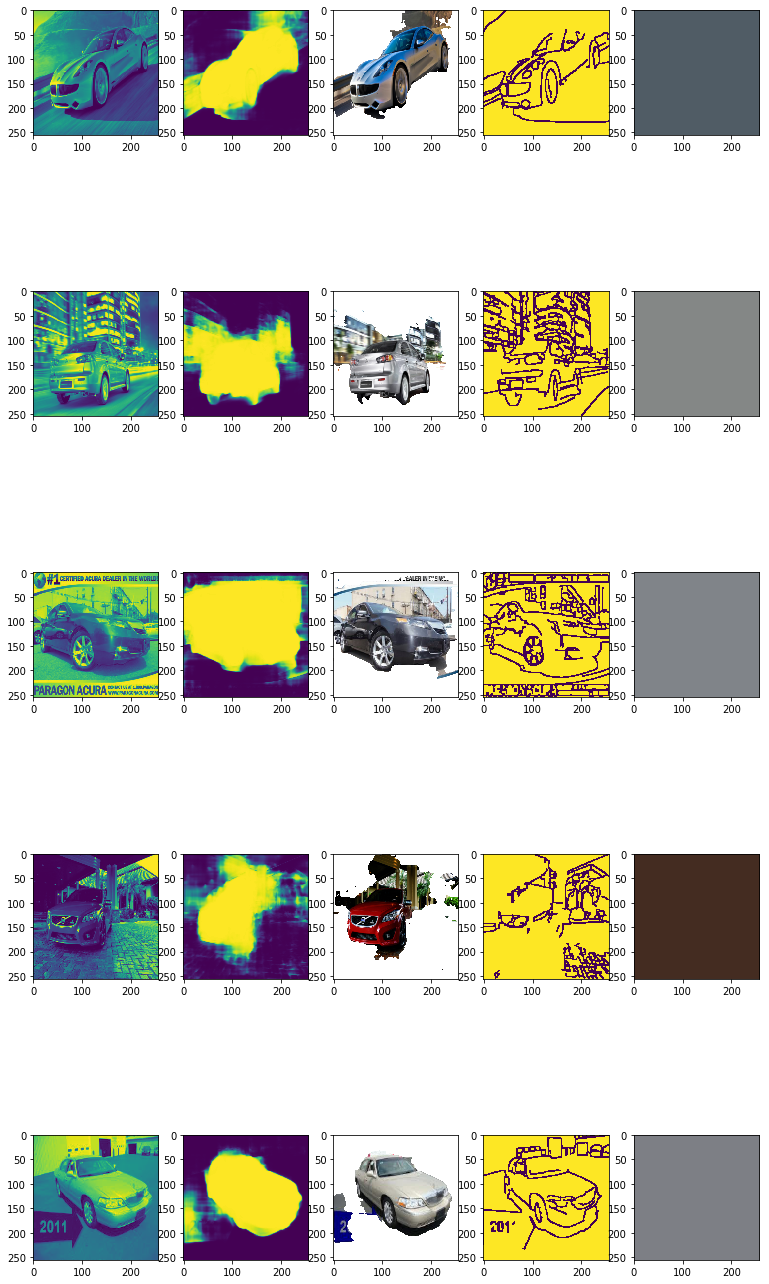

In [5]:
H = 256
W = 256

def downsample(img, h, w):    
    ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return ret
    #return cv2.resize(img, (h, w))
def get_clean_image(img,mask):    
    # img = cv2.imread(path)
    # img = cv2.resize(img, (h, w))
    # print(imshow(img))
    #mask = cv2.imread(maskimage)
    # mask=np.int8((imread(path_mask)))
    # print(mask)   
    # get first masked value (foreground)
    img = np.uint8(img)
    mask = np.uint8(mask)
    fg = cv2.bitwise_or(img, img, mask=mask)
    # get second masked value (background) mask must be inverted
    mask = cv2.bitwise_not(mask)
    background = np.full(img.shape, 255, dtype=np.uint8)
    bk = cv2.bitwise_or(background, background, mask=mask)

    # combine foreground+background
    final = cv2.bitwise_or(fg, bk)

    return final

import cv2
def get_edge_v2(img):
    blurred = cv2.GaussianBlur(img, (7,7), 0) # Remove noise
    #close the small line gaps using errosion
    kernel = np.ones((5,5), np.uint8)
    erode = cv2.erode(blurred, kernel, iterations = 1)
    #plt.imshow(erode)
    #cannyedge 
    def canny_edge_detector(input_img, threshold1, threshold2, draw=True, save=True):
        canny_img = cv2.cvtColor(np.copy(input_img), cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(canny_img, threshold1, threshold2)
        return edges
    #try adding Eroding before edge detection(increase black lines)
    canny_edges = canny_edge_detector(input_img=erode, threshold1=50, threshold2=180) 
    #return np.invert(canny_edges)
    #return np.invert(canny_edges)
    #plt.imshow(canny_edges)

    #close the small line gaps using dilation
    kernel = np.ones((3,3), np.uint8)
    dilation_canny = cv2.dilate(canny_edges, kernel, iterations = 1)
    return np.invert(dilation_canny)
    canny_blurred = cv2.GaussianBlur(dilation_canny, (3,3), 0) # Remove noise
    #invetimos la mascara queremos el blanco de fondo y el negro como dibujo del coche
    return np.invert(canny_blurred)

def get_avg_color_mask(img_reduct):
    avg=np.ones((H,W,3))
    #print(img_reduct[img_reduct[:,:,0]<255,0].mean())
    avg[...,:,0]=img_reduct[img_reduct[:,:,0]<255,0].mean()
    avg[...,:,1]=img_reduct[img_reduct[:,:,1]<255,1].mean()
    avg[...,:,2]=img_reduct[img_reduct[:,:,2]<255,2].mean()
    return avg

def get_img_info(img):
    #plt.imshow(img)
    #print("SHAPE-->", img.shape)
    #plt.show()
    lista=[]
    tmp = downsample(img,H,W)
    
    img = cv2.cvtColor(np.uint8(tmp), cv2.COLOR_RGB2GRAY).reshape(H,W,1)
    lista.append(img/255)
    lista.append(img/255)
    xpred = model.predict(np.array(lista).reshape(2,H,W,1))
    #plt.imshow(xpred[0].reshape(H,W))
    #plt.show()
    #print(np.max(img))
    final_car = get_clean_image(tmp, ((xpred[0]>0.5)*255))
    edge = get_edge_v2(np.uint8(tmp))
    #plt.imshow(final_car)
    #plt.show()
    avg = get_avg_color_mask(final_car)/255
    return img.reshape(H,W)/255, xpred[0].reshape(H,W), final_car/255, edge/255, avg

def myplot():
    # original predict mask only_car edges
    rows = 5
    fig,ax=plt.subplots(rows,5,figsize=(13,25))
    for x in range(rows):
        imgpath = randomimg[x]
        img = imread(imgpath)
        resized, mask, end_car, edges, avg = get_img_info(img)
        # shapes check and values check
        # print("resized",np.max(resized))
        # print("mask",np.max(mask))
        # print("end_car",np.max(end_car))
        # print("edges",np.max(edges))
        # print("avg",np.max(avg))
        ax[x,0].imshow(resized)
        ax[x,1].imshow(mask)
        ax[x,2].imshow(end_car)
        ax[x,3].imshow(edges)
        ax[x,4].imshow(avg)
# Vamos a hacer print de unas 10 imagenes random
randomimg = np.random.choice(images,250)
myplot()
#randomimg
#img1 = imread(randomimg[135])
#plot_img_and_info(img1)


In [6]:

def generator_for_standford(paths, batch_size, h, w):
    
    while True:
        edges_in=[]
        color_mask_in=[]

        bw_img_out=[]
        end_img_out=[]
        for x in range(batch_size):
            randomimg = np.random.choice(paths,1)
            img = imread(randomimg[0])
            # a few images on dataset are black white with dimension 2 and not valid
            while True:
                if (img.ndim == 3) & (img.shape[0]>256):
                    #print("break")
                    break
                #print(img.ndim, img.shape)
                randomimg = np.random.choice(paths,1)
                img = imread(randomimg[0])
            resized, mask, end_car, edges, avg = get_img_info(img)
            img_bw = cv2.cvtColor(np.uint8(end_car*255), cv2.COLOR_RGB2GRAY)
            edges_in.append(edges.reshape(h,w,1))
            color_mask_in.append(avg)
            bw_img_out.append(img_bw.reshape(h,w,1)/255)
            end_img_out.append(end_car)
        
        yield [np.array(edges_in),np.array(color_mask_in)], [np.array(bw_img_out),np.array(end_img_out)]
#shapes and values check    

inputs,outputs = next(generator_for_standford(images,5, H, W))
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs[0].shape)
print(outputs[1].shape)

print(np.max(inputs[0]))
print(np.max(inputs[1]))
print(np.max(outputs[0]))
print(np.max(outputs[1]))

(5, 256, 256, 1)
(5, 256, 256, 3)
(5, 256, 256, 1)
(5, 256, 256, 3)
1.0
0.6196157445189807
1.0
1.0


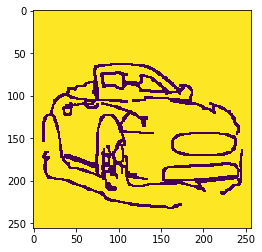

In [7]:
plt.imshow(inputs[0][0].reshape(H,W))

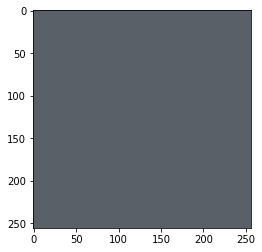

In [8]:
plt.imshow(inputs[1][0])

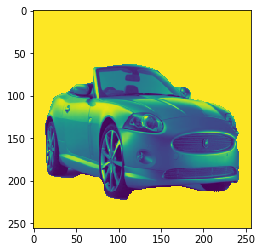

In [9]:
plt.imshow(outputs[0][0].reshape(H,W))

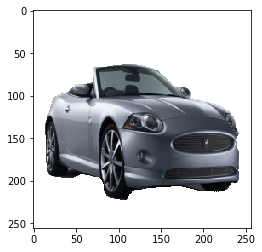

In [10]:
plt.imshow(outputs[1][0])

In [11]:


from sklearn.model_selection import train_test_split
train_input, test_input, _, _ = train_test_split(images, images, test_size=0.15, random_state=42)
print(len(train_input))
print(len(test_input))


13757
2428


In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True, chanels_out=1):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    #, activation='none'
    outputs = Conv2D(chanels_out, (1, 1), activation='sigmoid') (c9)
    # model = Model(inputs=[input_img], outputs=[outputs])
    return outputs

In [13]:
input_edge = Input(shape=(256, 256, 1), name="edge")  # adapt this if using `channels_first` image data format
input_color = Input(shape=(256, 256, 3), name="color")  # adapt this if using `channels_first` image data format

outedge = get_unet(input_edge, n_filters=64, dropout=0.5, batchnorm=True,chanels_out=1)

subtracted = keras.layers.Subtract()([input_color, outedge])
# mult = keras.layers.multiply([input_color, outedge])
colorcar = get_unet(subtracted, n_filters=64, dropout=0.5, batchnorm=True,chanels_out=3)

model_std = Model([input_edge, input_color],[outedge, colorcar])
model_std.compile(optimizer='Adadelta', loss=['binary_crossentropy','binary_crossentropy'])
              #, loss_weights=[100, 1])
model_std.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
edge (InputLayer)               (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         edge[0][0]                       
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
!pip install livelossplot

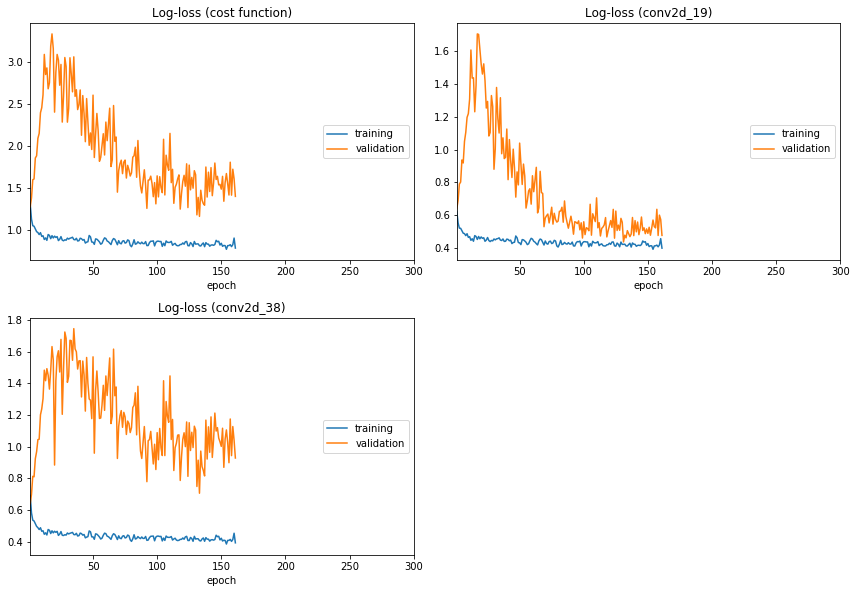

Log-loss (cost function):
training   (min:    0.776, max:    1.313, cur:    0.790)
validation (min:    1.167, max:    3.333, cur:    1.404)

Log-loss (conv2d_19):
training   (min:    0.392, max:    0.622, cur:    0.399)
validation (min:    0.437, max:    1.704, cur:    0.477)

Log-loss (conv2d_38):
training   (min:    0.384, max:    0.691, cur:    0.392)
validation (min:    0.639, max:    1.745, cur:    0.928)
Epoch 162/300
 4/15 [=======>......................] - ETA: 33s - loss: 0.8360 - conv2d_19_loss: 0.4229 - conv2d_38_loss: 0.4131

In [15]:
from livelossplot.keras import PlotLossesCallback

# initialize the number of epochs and batch size
# definimos nuestro callback para guardar
saver = ModelCheckpoint('unet_standford_edges_to_image.hdf5', save_best_only=True, monitor='val_loss', mode='min')

EPOCHS = 300
BS = 10

# train the network
histor=model_std.fit_generator(generator_for_standford(train_input,BS,H,W),
    validation_data=(generator_for_standford(test_input,BS,H,W)), steps_per_epoch=15, 
    validation_steps = 10,
    epochs=EPOCHS, callbacks=[saver,PlotLossesCallback()])


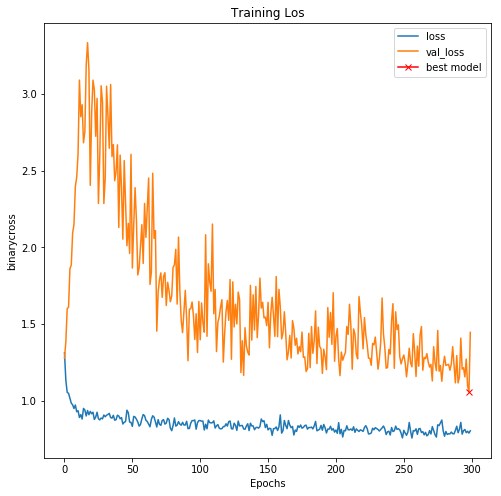

In [16]:
plt.figure(figsize=(8, 8))
plt.title("Training Los")
plt.plot(histor.history["loss"], label="loss")
plt.plot(histor.history["val_loss"], label="val_loss")
plt.plot( np.argmin(histor.history["val_loss"]), np.min(histor.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("binarycross")
plt.legend();

In [17]:
model2 = load_model('unet_standford_edges_to_image.hdf5')

In [18]:
# inputs, outputs= next(generator_int(train_input,32,False))

In [19]:
inputs, outputs= next(generator_for_standford(test_input,5,H,W))
preds = model2.predict([inputs[0],inputs[1]])
print(preds[0].shape)

(5, 256, 256, 1)


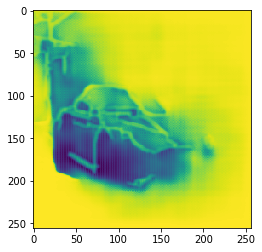

In [20]:
plt.imshow(preds[0][1].reshape(H,W))

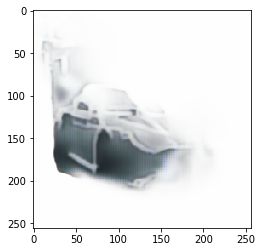

In [21]:
plt.imshow(preds[1][1])

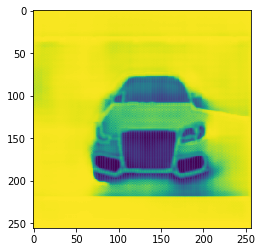

In [22]:
plt.imshow(preds[0][2].reshape(H,W))

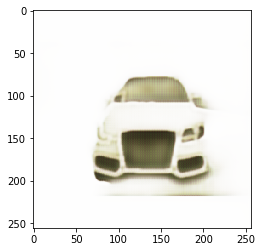

In [23]:
plt.imshow(preds[1][2])

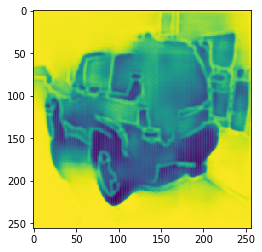

In [24]:
plt.imshow(preds[0][3].reshape(H,W))

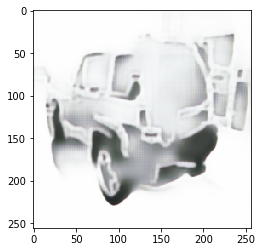

In [25]:
plt.imshow(preds[1][3])

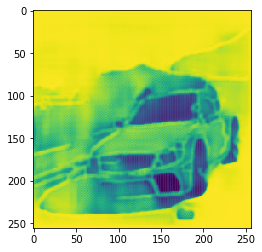

In [26]:
plt.imshow(preds[0][4].reshape(H,W))

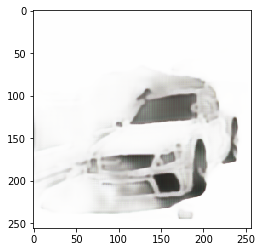

In [27]:
plt.imshow(preds[1][4])

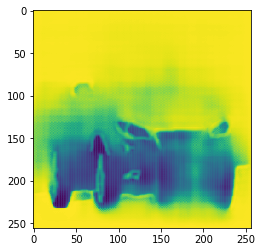

In [28]:
plt.imshow(preds[0][0].reshape(H,W))

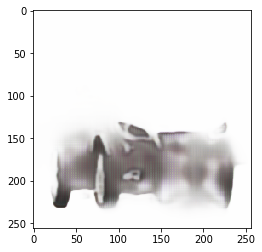

In [29]:
plt.imshow(preds[1][0])

In [30]:
#END DEL NOTEBOOK 